In [1]:
from utils.shuqing_all import *

In [2]:
import pandas as pd
import numpy as np
import os
from numpy.linalg import matrix_power
from numpy import linalg as LA
np.set_printoptions(suppress=True)

In [3]:
PROJECT = 'uw-data-warehouse-prod'

In [834]:
# """
# SELECT * FROM `uw-data-models-prod.partner_dataform_models_feature_catalogue.partner_position_rfm_score` a
# LEFT JOIN 

# (SELECT snapshot_date, partner_position_id, partner_value_last_1y as value
# FROM `uw-data-models-prod.partner_dataform_models_feature_catalogue.partner_value_last_period`
#  WHERE snapshot_date='2021-09-17' OR snapshot_date='2021-08-24' ) b
#  ON a.partner_position_id = b.partner_position_id
#  AND a.snapshot_date = b.snapshot_date
# WHERE (a.snapshot_date='2021-09-17' OR a.snapshot_date='2021-08-24')
# AND is_rfm_eligible=true
# """

In [4]:
rfm="""
with table_aug2021 as (
Select *
    , CASE
                WHEN NOT a.is_live THEN "closed account"
                WHEN NOT a.is_rfm_eligible AND a.is_live THEN "not eligible"
                WHEN a.is_rfm_eligible AND a.is_live THEN CAST(rfm_score AS string)  else '99' end as closed_acc_status_aug
            --,r.rfm_score as rfm_sep, r.is_live, r.is_rfm_eligible
            from `uw-data-models-prod.partner_dataform_models_feature_catalogue.partner_position_rfm_score` a
        where a.snapshot_date in ('2021-08-24') and (closure_months <=18 or closure_months is null)
),
table_sept2021  as
(
    Select partner_position_id, snapshot_date, a.rfm_score as rfm_sep
    , CASE
                WHEN NOT a.is_live THEN "closed account"
                WHEN NOT a.is_rfm_eligible AND a.is_live THEN "not eligible"
                WHEN a.is_rfm_eligible AND a.is_live THEN CAST(rfm_score AS string) else '99' end as closed_acc_status_sep
            from `uw-data-models-prod.partner_dataform_models_feature_catalogue.partner_position_rfm_score` a
        where a.snapshot_date in ('2021-09-17') and (closure_months <=18 or closure_months is null)
)
select * from (
        select *
        from table_aug2021 a
        left join table_sept2021 b on a.partner_position_id = b.partner_position_id
        left join 
(SELECT snapshot_date, partner_position_id, partner_value_last_1y as value
FROM `uw-data-models-prod.partner_dataform_models_feature_catalogue.partner_value_last_period`
 WHERE snapshot_date='2021-09-17' OR snapshot_date='2021-08-24') c
 ON b.partner_position_id = c.partner_position_id
 AND b.snapshot_date = c.snapshot_date
)

where (closed_acc_status_aug != 'not eligible' and closed_acc_status_sep != 'not eligible')
"""

In [5]:
rfm_df=download_data(project_id=PROJECT,query=rfm)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-3425ks60hkk80fssi9vpohv88g6q1iqd.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=JU6etgV6CAT6KgSH8CuWV5hQKJEN9o&prompt=consent&access_type=offline
Enter the authorization code: 4/1AX4XfWgstI49w6dCHXDlE7gf2JABpoJLbCYCmsA2ppSbs5xs67Qj9nMXi98


Downloading:   0%|          | 0/38209 [00:00<?, ?rows/s]

In [6]:
# change 'value' to correct dtype
rfm_df['value']=np.round(rfm_df.value.astype(float),2)

In [7]:
rfm_df.snapshot_date.value_counts()

2021-08-24    38209
Name: snapshot_date, dtype: int64

In [839]:
# #create df for each group
# group_1=rfm_df.loc[rfm_df.title_group=='group_1'].reset_index(drop=True)
# group_2=rfm_df.loc[rfm_df.title_group=='group_2'].reset_index(drop=True)
# group_3=rfm_df.loc[rfm_df.title_group=='group_3'].reset_index(drop=True)

# All Groups

In [840]:
random_df=rfm_df.loc[:,['partner_position_id','closed_acc_status_aug','closed_acc_status_sep']]

In [245]:
# # pivot snapshot_date col to have each snapshot_date as col, under each col sits rfm score, fillna with churned(99 number int)
# # group_1_partner_list=group_1.loc[group_1.snapshot_date=='2021-01-01','partner_position_id'].tolist()
# pivoted=rfm_df.loc[:,['partner_position_id','snapshot_date','aug_rfm_status','sep_close_accounts']].pivot(index='partner_position_id',columns='snapshot_date').fillna(99)


In [426]:
# for c in pivoted.columns:
#     print(c[1].date().isoformat())

In [427]:
# pivoted.columns[:2]

In [248]:
# # add snapshot date to its corresponding rfm value 
# for c in pivoted.columns[:2]:
#     pivoted[c]=f"{c[1].date().isoformat()} "+'rfm:'+pivoted[c].astype(str)

In [257]:
# pivoted

In [233]:
# dfs=[]
# # get initial and current snapshot
# p=(pivoted.columns[0],pivoted.columns[1],pivoted.columns[2])
# # group df by initial and current snapshot_date and count the size of each group
# # it will help see the volume of people transition from each combination of rfm score on those two dates 
# _d=pivoted.groupby(list(p)).size().reset_index(name='count')
# _d.columns=['from','to','close_accounts','count']
# dfs.append(_d)
# df=pd.concat(dfs).reset_index(drop=True)

In [8]:
df=rfm_df.loc[:,['partner_position_id','closed_acc_status_aug','closed_acc_status_sep']].groupby([
    'closed_acc_status_aug','closed_acc_status_sep']).size().reset_index(name='count')


In [9]:
df.columns=['from','to','count']

In [10]:
df

,from,to,count
0,0,0,2576
1,0,4,44
2,0,5,1
3,0,closed account,103
4,1,0,586
...,...,...,...
71,closed account,4,21
72,closed account,5,2
73,closed account,7,1
74,closed account,9,1


In [767]:
# #drop those partners who are not geuninely close accounts(just become not eligible) and who didn't appear on '2021-08-24'

# df.drop(df[((df['to']=='2021-09-17 rfm:99.0')&(df.close_accounts==False))|(df['from']=='2021-08-24 rfm:not eligible')|(df['from']=='2021-08-24 rfm:99')].index,axis=0)

In [11]:
# state_lists=['rfm:0.0','rfm:1.0','rfm:2.0','rfm:3.0','rfm:4.0','rfm:5.0','rfm:6.0','rfm:7.0',
#             'rfm:8.0','rfm:9.0','rfm:10.0','rfm:11.0','rfm:12.0','rfm:13.0','rfm:99.0']
# create the criteria of only including partners within state_list
# f=(df['from'].str.split().str[1].isin(state_lists))&(
#     df['to'].str.split().str[1].isin(state_lists))
#get the matrix
matrix_df=df[['from','to','count']].reset_index(drop=True).copy()
#sort values
matrix_df.sort_values(by=['from','to'],inplace=True)
# replace string with int 99
matrix_df.loc[matrix_df['from']=='closed account','from']=99
matrix_df.loc[matrix_df['to']=='closed account','to']=99

In [12]:
# # strip the string of 'rfm:' from value 
# matrix_df['from']=matrix_df['from'].str.split().str[1].str.split(':').str[1].astype(float).astype(int)
# matrix_df['to']=matrix_df['to'].str.split().str[1].str.split(':').str[1].astype(float).astype(int)

# update 'from' to int dtype and pivot matrix
matrix_df['from']=matrix_df['from'].astype(int)
matrix_df['to']=matrix_df['to'].astype(int)
final_df=matrix_df.pivot(index='from',columns='to').fillna(0).astype(int)

In [13]:
matrix_df

,from,to,count
0,0,0,2576
1,0,4,44
2,0,5,1
3,0,99,103
4,1,0,586
...,...,...,...
71,99,4,21
72,99,5,2
73,99,7,1
74,99,9,1


In [14]:
final_df

count                                                                   
to      0     1     2     3     4    5    6    7    8   9  10 11 12 13     99
from                                                                         
0     2576     0     0     0    44    1    0    0    0   0  0  0  0  0    103
1      586  2109     0     0    47    0    0    0    0   0  0  0  0  0    122
2       14   869  1833     1   111    5    3    1    0   0  0  0  0  0    143
3        6    14   886  1461   151   12    5    0    0   0  0  0  0  0    133
4        0     4     9   835  1760   92   56    5    0   0  0  0  0  0     40
5        0     0     2    16   209  327   80    4    1   3  0  0  0  0      9
6        0     0     0     1    28  129  481   23    4   0  0  0  0  0      2
7        0     0     1     1     5    5   51  111   25   1  0  0  0  0      2
8        0     0     0     0     4    0    4   21  143   6  0  0  0  0      2
9        0     0     0     0     0    0    0    0   15  54  1  0  0  0      0
10       0     0     0     0     0    0    0    0    0   0  5  0  0  0      0
11       0     0     0     0     0    0    0    0    0   0  0  6  3  0      0
13       0     0     0     0     0    0    0    0    0   0  0  0  0  2      0
99       0     0     0     0    21    2    0    1    0   1  0  0  0  0  22360

In [105]:
# calculate current number of partners and current value of network
volume=rfm_df.loc[rfm_df.snapshot_date_1=='2021-09-17'].groupby(['closed_acc_status_sep'])['partner_position_id'].count()
value=rfm_df.loc[rfm_df.snapshot_date_1=='2021-09-17'].groupby(['closed_acc_status_sep'])['value'].median()
# sort volume by ascending rfm score

volume=volume[:-1].sort_values(ascending=False)
value=value[:-1].sort_values(ascending=True)
test=volume.reset_index()
test['closed_acc_status_sep']=test['closed_acc_status_sep'].astype(int)
test=test.sort_values(by=['closed_acc_status_sep'])
volume=test.set_index('closed_acc_status_sep').partner_position_id
#sort value by ascending rfm score
test=value.reset_index()
test['closed_acc_status_sep']=test['closed_acc_status_sep'].astype('int')
test=test.sort_values(by=['closed_acc_status_sep'])
value=test.set_index('closed_acc_status_sep').value

initial_totals=volume * value

#only inclue volume and value that have the same rfm score as final_df index 
volume=volume[final_df.index.tolist()[:-1]]
value=value[final_df.index.tolist()[:-1]]
#assign 99(close accounts) to volume 
volume[99]=22916
volume_totals=volume

# # initial totals has to have the same length as final_df, exclude last one 99 (closed account)
initial_totals=initial_totals[final_df.index.tolist()[:-1]].copy()
# assign 99 value to close account row to start with 
#final_df.sum(axis=1)[99]
initial_totals[99]=0

#assign 99 close close accounts to value 
value[99]=0
#value index has to be from 0-13, can't have 99 index, should be consistent with simulated volume later (from 0-13)
value=value.reset_index(drop=True)

In [106]:
value

0        1.00
1        1.00
2        6.20
3        9.30
4       14.60
5       66.60
6      111.80
7      208.00
8      297.15
9      474.70
10     579.30
11    1223.30
12    1526.75
13       0.00
Name: value, dtype: float64

In [107]:
volume

closed_acc_status_sep
0      3182
1      2996
2      2731
3      2315
4      2380
5       573
6       680
7       166
8       188
9        65
10        6
11        6
13        2
99    22916
Name: partner_position_id, dtype: int64

In [109]:
initial_totals

closed_acc_status_sep
0      3182.0
1      2996.0
2     16932.2
3     21529.5
4     34748.0
5     38161.8
6     76024.0
7     34528.0
8     55864.2
9     30855.5
10     3475.8
11     7339.8
13     3053.5
99        0.0
dtype: float64

In [173]:
initial_totals.sum()

328690.3

In [110]:
# different len of rows and cols
final_df

count                                                                   
to      0     1     2     3     4    5    6    7    8   9  10 11 12 13     99
from                                                                         
0     2576     0     0     0    44    1    0    0    0   0  0  0  0  0    103
1      586  2109     0     0    47    0    0    0    0   0  0  0  0  0    122
2       14   869  1833     1   111    5    3    1    0   0  0  0  0  0    143
3        6    14   886  1461   151   12    5    0    0   0  0  0  0  0    133
4        0     4     9   835  1760   92   56    5    0   0  0  0  0  0     40
5        0     0     2    16   209  327   80    4    1   3  0  0  0  0      9
6        0     0     0     1    28  129  481   23    4   0  0  0  0  0      2
7        0     0     1     1     5    5   51  111   25   1  0  0  0  0      2
8        0     0     0     0     4    0    4   21  143   6  0  0  0  0      2
9        0     0     0     0     0    0    0    0   15  54  1  0  0  0      0
10       0     0     0     0     0    0    0    0    0   0  5  0  0  0      0
11       0     0     0     0     0    0    0    0    0   0  0  6  3  0      0
13       0     0     0     0     0    0    0    0    0   0  0  0  0  2      0
99       0     0     0     0    21    2    0    1    0   1  0  0  0  0  22360

In [111]:
#final_df len(rows) should equal len(cols): take cols that not in rwos
final_df=final_df.iloc[:,[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13,14]].copy()

In [112]:
final_df

count                                                                
to      0     1     2     3     4    5    6    7    8   9  10 11 13     99
from                                                                      
0     2576     0     0     0    44    1    0    0    0   0  0  0  0    103
1      586  2109     0     0    47    0    0    0    0   0  0  0  0    122
2       14   869  1833     1   111    5    3    1    0   0  0  0  0    143
3        6    14   886  1461   151   12    5    0    0   0  0  0  0    133
4        0     4     9   835  1760   92   56    5    0   0  0  0  0     40
5        0     0     2    16   209  327   80    4    1   3  0  0  0      9
6        0     0     0     1    28  129  481   23    4   0  0  0  0      2
7        0     0     1     1     5    5   51  111   25   1  0  0  0      2
8        0     0     0     0     4    0    4   21  143   6  0  0  0      2
9        0     0     0     0     0    0    0    0   15  54  1  0  0      0
10       0     0     0     0     0    0    0    0    0   0  5  0  0      0
11       0     0     0     0     0    0    0    0    0   0  0  6  0      0
13       0     0     0     0     0    0    0    0    0   0  0  0  2      0
99       0     0     0     0    21    2    0    1    0   1  0  0  0  22360

In [114]:
print(final_df.shape,initial_totals.shape,volume_totals.shape)

(14, 14) (14,) (14,)


In [115]:
# calculate how many people transtition from initial state to current state in percentage
total_percentage=[]
for idx, row in final_df.iterrows():
    # for each row, what's the percentage of each col 
    row_percentage=[p/sum(row) for p in row]
    # sum of row_percentage should be 1 for each row, this is to check the validity of the calculation
    print(sum(row_percentage))
    total_percentage.append(row_percentage)

1.0
1.0
1.0000000000000002
0.9999999999999999
1.0000000000000002
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0


In [116]:
percentage=pd.DataFrame(total_percentage)

In [117]:
percentage

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.945668,0.000000,0.000000,0.000000,0.016153,0.000367,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.037812
1,0.204609,0.736383,0.000000,0.000000,0.016411,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.042598
2,0.004698,0.291611,0.615101,0.000336,0.037248,0.001678,0.001007,0.000336,0.000000,0.000000,0.000000,0.0,0.0,0.047987
3,0.002249,0.005247,0.332084,0.547601,0.056597,0.004498,0.001874,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.049850
4,0.000000,0.001428,0.003213,0.298108,0.628347,0.032845,0.019993,0.001785,0.000000,0.000000,0.000000,0.0,0.0,0.014281
5,0.000000,0.000000,0.003072,0.024578,0.321045,0.502304,0.122888,0.006144,0.001536,0.004608,0.000000,0.0,0.0,0.013825
6,0.000000,0.000000,0.000000,0.001497,0.041916,0.193114,0.720060,0.034431,0.005988,0.000000,0.000000,0.0,0.0,0.002994
7,0.000000,0.000000,0.004950,0.004950,0.024752,0.024752,0.252475,0.549505,0.123762,0.004950,0.000000,0.0,0.0,0.009901
8,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.022222,0.116667,0.794444,0.033333,0.000000,0.0,0.0,0.011111
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.214286,0.771429,0.014286,0.0,0.0,0.000000


In [118]:
# make it np array
initials=np.array(initial_totals)
initials_volume=np.array(volume_totals)

In [119]:
# make it np array
p=np.array(percentage)

In [120]:
print(percentage.shape,initials.shape,initials_volume.shape)

(14, 14) (14,) (14,)


In [121]:
#percentage times by itself multiple times 
times1=matrix_power(np.array(percentage),1)

In [122]:
times5=matrix_power(np.array(percentage),5)

In [123]:
# quality check that times sum to 1 each row
pd.DataFrame(times5).sum(axis=1)

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
dtype: float64

In [124]:
times10=matrix_power(np.array(percentage),10)

In [125]:
times50=matrix_power(np.array(percentage),50)

In [126]:
times100=matrix_power(np.array(percentage),100)

In [127]:
times500=matrix_power(np.array(percentage),500)

In [128]:
initials_volume

array([ 3182,  2996,  2731,  2315,  2380,   573,   680,   166,   188,
          65,     6,     6,     2, 22916])

In [129]:
# use inititals_volume and times1 dot product to get simulation of what inititals_volume will be after period 1
a_1=np.round(initials_volume.dot(times1))

In [131]:
a_2=np.round(initials_volume.dot(times5))

In [132]:
a_3=np.round(initials_volume.dot(times10))

In [133]:
a_4=np.round(initials_volume.dot(times50))

In [134]:
a_5=np.round(initials_volume.dot(times100))

In [135]:
a_6=np.round(initials_volume.dot(times500))

In [136]:
pd.concat([pd.Series(initials_volume),pd.Series(a_1),pd.Series(a_2),pd.Series(a_3),
           pd.Series(a_4),pd.Series(a_5),pd.Series(a_6)],axis=1).astype(int)

,0,1,2,3,4,5,6
0,3182,3640,5111,5770,2073,745,512
1,2996,3018,2454,1524,262,150,132
2,2731,2459,1489,875,213,130,116
3,2315,1994,1192,791,232,146,132
4,2380,2071,1394,1015,332,216,196
5,573,520,376,265,68,45,41
6,680,661,516,366,83,53,48
7,166,146,111,84,21,15,15
8,188,189,169,135,33,24,23
9,65,61,49,39,14,12,12


In [139]:
# calculate network value by multiplying each iteration volume
v_1=pd.Series(a_1)*value
v_2=pd.Series(a_2)*value
v_3=pd.Series(a_3)*value
v_4=pd.Series(a_4)*value
v_5=pd.Series(a_5)*value
v_6=pd.Series(a_6)*value

In [140]:
# make network value table
table=pd.DataFrame(pd.concat([pd.Series(initials),v_1,v_2,v_3,
           v_4,v_5,v_6],axis=1).sum(),columns=['network_value'])

In [141]:
table

,network_value
0,328690.30
1,309150.85
2,243718.15
3,187486.85
4,70743.45
5,61751.60
6,98682.15


In [142]:
# graph iteration graph 
values_50=[]
iteration_list=[]
for i in range(1,51):
    # get matrix 
    times=matrix_power(np.array(percentage),i)
    # calculate volume after iteration
    a=np.round(initials_volume.dot(times))
    # calculate value after iteration
    v=pd.Series(a)*value
    values_50.append(v)
    iteration_list.append(i)

In [143]:
# create df for graph
graph_t=pd.DataFrame(pd.concat(values_50,axis=1).sum(),columns=['Network value at base'])
graph_t['iteration']=iteration_list

In [144]:
graph_t

,Network value at base,iteration
0,309150.85,1
1,290653.20,2
2,273849.45,3
3,258133.25,4
4,243718.15,5
5,230790.60,6
6,218901.95,7
7,207424.30,8
8,197522.20,9
9,187486.85,10


(array([ 50000., 100000., 150000., 200000., 250000., 300000., 350000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

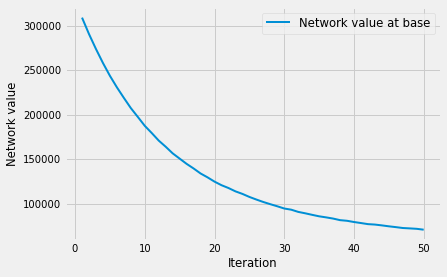

In [882]:
graph_t.set_index('iteration').plot(linewidth=2)
plt.legend(fontsize='small')
plt.xlabel('Iteration',fontsize='small')
plt.ylabel('Network value',fontsize='small')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Senario One
## Reallocate 1%, 2%, 3%, 4%, 5% from Dormant (0-6) to Semi-Dormant (7-11)

In [23]:
import random

In [24]:
# create df for reallocation
random_df=rfm_df.loc[:,['partner_position_id','closed_acc_status_aug','closed_acc_status_sep']]

In [25]:
# replace 'close accounts' with 99 
random_df.loc[random_df.closed_acc_status_aug=='closed account','closed_acc_status_aug']=99
random_df.loc[random_df.closed_acc_status_sep=='closed account','closed_acc_status_sep']=99
random_df['closed_acc_status_aug']=random_df['closed_acc_status_aug'].astype(int)
random_df['closed_acc_status_sep']=random_df['closed_acc_status_sep'].astype(int)

In [26]:
# count of rfm score in (0,6)
random_df.loc[random_df.closed_acc_status_sep.isin(range(0,7)),'closed_acc_status_sep'].value_counts().sum()

14857

In [27]:
# random select 1% from base (0,6)
one_percent=random_df.loc[random_df.closed_acc_status_sep.isin(range(0,7))].sample(frac=0.01,random_state=402)

In [28]:
one_percent

,partner_position_id,closed_acc_status_aug,closed_acc_status_sep
14023,L10173,2,2
13295,L57809,0,0
8332,AA6629,2,2
15762,654783,0,0
10909,N73220,1,1
...,...,...,...
3446,AB5141,1,1
9192,AA2304,6,6
10713,N74820,4,4
2942,AB6381,2,1


In [29]:
# drop one percent from (0,6)
random_df=random_df.drop(random_df[random_df.partner_position_id.isin(one_percent.partner_position_id.tolist())].index,0)

In [30]:
# move one percent to (7,11) by randomly assigning (7-11) to those partners 
for i in one_percent.partner_position_id.tolist():
    one_percent.loc[one_percent.partner_position_id==i,'closed_acc_status_sep']=random.randint(7,11)

In [31]:
# append new one percent back to df 
new_df=pd.concat([random_df,one_percent])

In [32]:
# count of rfm score in (0,6)
new_df.loc[new_df.closed_acc_status_sep.isin(range(0,7)),'closed_acc_status_sep'].value_counts().sum()

14708

In [33]:
# compared count of 0-6 before and after the 1% reallocation
14857-14708

149

In [34]:
new_df

,partner_position_id,closed_acc_status_aug,closed_acc_status_sep
0,AB9831,4,4
1,AB9905,4,99
2,AB9760,4,4
3,AB9819,4,4
4,AB9865,4,4
...,...,...,...
3446,AB5141,1,9
9192,AA2304,6,10
10713,N74820,4,11
2942,AB6381,2,11


In [35]:
# repeat the same thing for moving (7-11) to (12-13)
random_df=new_df.loc[:,['partner_position_id','closed_acc_status_aug','closed_acc_status_sep']]
one_percent=random_df.loc[random_df.closed_acc_status_sep.isin(range(7,12))].sample(frac=0.01,random_state=402)

In [36]:
random_df.loc[random_df.closed_acc_status_sep.isin(range(7,12)),'closed_acc_status_sep'].value_counts().sum()

580

In [37]:
random_df=random_df.drop(random_df[random_df.partner_position_id.isin(one_percent.partner_position_id.tolist())].index,0)
for i in one_percent.partner_position_id.tolist():
    one_percent.loc[one_percent.partner_position_id==i,'closed_acc_status_sep']=random.randint(12,13)
new_df=pd.concat([random_df,one_percent])

In [38]:
new_df.loc[new_df.closed_acc_status_sep.isin(range(7,12)),'closed_acc_status_sep'].value_counts().sum()

574

In [39]:
574-len(one_percent)

568

In [40]:
len(one_percent)

6

In [55]:
volume_1percent

closed_acc_status_sep
0     3153
1     2963
2     2694
3     2293
4     2362
5      569
6      674
7      188
8      210
9       90
10      46
11      40
12       6
13       5
Name: partner_position_id, dtype: int64

In [151]:
volume_1percent=new_df.groupby(['closed_acc_status_sep'])['partner_position_id'].count()
volume_1percent=volume_1percent[:-1].sort_values(ascending=False)

test=volume_1percent.reset_index()
test['closed_acc_status_sep']=test['closed_acc_status_sep'].astype(int)
test=test.sort_values(by=['closed_acc_status_sep'])
volume_1percent=test.set_index('closed_acc_status_sep').partner_position_id

p_value=rfm_df.loc[rfm_df.snapshot_date_1=='2021-09-17'].groupby(['closed_acc_status_sep'])['value'].median()
p_value=p_value[:-1].sort_values(ascending=True)
test=p_value.reset_index()
test['closed_acc_status_sep']=test['closed_acc_status_sep'].astype('int')
test=test.sort_values(by='closed_acc_status_sep',ascending=True).set_index('closed_acc_status_sep')['value']
totals_1percent=test * volume_1percent
p_value=test

p_value=p_value[final_df.index.tolist()[:-1]]
p_value=p_value.reset_index().value
# same thing for volume
volume_1percent=volume_1percent[final_df.index.tolist()[:-1]]
volume_1percent[99]=22916
# # initial totals has to have the same length as final_df, exclude last one 99 (closed account)

totals_1percent=totals_1percent[final_df.index.tolist()[:-1]]
totals_1percent[99]=0
p_value[99]=0
p_value=p_value.reset_index(drop=True)

In [166]:
volume_1percent

closed_acc_status_sep
0      3153
1      2963
2      2694
3      2293
4      2362
5       569
6       674
7       188
8       210
9        90
10       46
11       40
13        5
99    22916
Name: partner_position_id, dtype: int64

In [167]:
p_value

0        1.00
1        1.00
2        6.20
3        9.30
4       14.60
5       66.60
6      111.80
7      208.00
8      297.15
9      474.70
10     579.30
11    1223.30
12    1526.75
13       0.00
Name: value, dtype: float64

In [152]:
totals_1percent

closed_acc_status_sep
0      3153.00
1      2963.00
2     16702.80
3     21324.90
4     34485.20
5     37895.40
6     75353.20
7     39104.00
8     62401.50
9     42723.00
10    26647.80
11    48932.00
13     7633.75
99        0.00
dtype: float64

In [ ]:
totals_1percent.sum()

In [153]:
print(totals_1percent.shape,volume_1percent.shape,final_df.shape)

(14,) (14,) (14, 14)


In [154]:
# make it np array
initials=np.array(totals_1percent)
initials_volume=np.array(volume_1percent)

In [155]:
# use inititals_volume and times1 dot product to get simulation of what inititals_volume will be after period 1
p_1=np.round(initials_volume.dot(times1))
p_2=np.round(initials_volume.dot(times5))
p_3=np.round(initials_volume.dot(times10))
p_4=np.round(initials_volume.dot(times50))
p_5=np.round(initials_volume.dot(times100))
p_6=np.round(initials_volume.dot(times500))

In [156]:
pd.concat([pd.Series(initials_volume),pd.Series(p_1),pd.Series(p_2),pd.Series(p_3),
           pd.Series(p_4),pd.Series(p_5),pd.Series(p_6)],axis=1).astype(int)

,0,1,2,3,4,5,6
0,3153,3606,5058,5711,2067,743,511
1,2963,2983,2427,1512,262,150,132
2,2694,2429,1476,870,213,130,116
3,2293,1977,1185,790,232,146,132
4,2362,2056,1388,1014,332,215,196
5,569,516,378,268,68,45,41
6,674,662,524,374,84,53,48
7,188,161,119,89,22,15,15
8,210,214,192,150,33,24,23
9,90,81,59,44,14,12,12


In [157]:
p_v_1=pd.Series(p_1)*value
p_v_2=pd.Series(p_2)*value
p_v_3=pd.Series(p_3)*value
p_v_4=pd.Series(p_4)*value
p_v_5=pd.Series(p_5)*value
p_v_6=pd.Series(p_6)*value

In [158]:
# make network value table
p_table=pd.DataFrame(pd.concat([pd.Series(initials),p_v_1,p_v_2,p_v_3,
           p_v_4,p_v_5,p_v_6],axis=1).sum(),columns=['network_value'])

In [159]:
p_table.astype(int)

,network_value
0,419319
1,397751
2,327601
3,266828
4,141560
5,132238
6,169184


In [160]:
p_table.astype(int).values[0]-table.values[0].astype(int)

array([90629])

In [161]:
# graph iteration graph 
values_50=[]
iteration_list=[]
for i in range(1,51):
    # get matrix 
    times=matrix_power(np.array(percentage),i)
    # calculate volume after iteration
    a=np.round(initials_volume.dot(times))
    # calculate value after iteration
    v=pd.Series(a)*value
    values_50.append(v)
    iteration_list.append(i)
    
# create df for graph
p_graph_t=pd.DataFrame(pd.concat(values_50,axis=1).sum(),columns=['network_value'])
p_graph_t['iteration']=iteration_list

In [162]:
compare_df=pd.concat([p_graph_t,graph_t],axis=1)
compare_df=compare_df.iloc[:,:3]
compare_df.columns=['Network value after 1% reallocation',
                'iteration','Network value base']

In [163]:
(compare_df['Network value base']-compare_df['Network value after 1% reallocation']).mean()

-75014.59200000002

(array([ 50000., 100000., 150000., 200000., 250000., 300000., 350000.,
        400000., 450000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

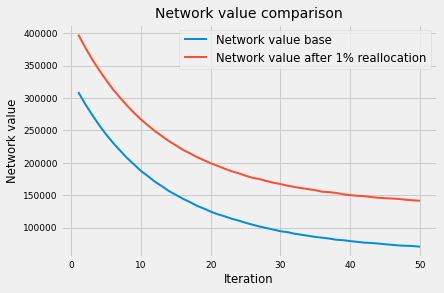

In [170]:
compare_df.set_index('iteration')['Network value base'].plot(linewidth=2)
compare_df.set_index('iteration')['Network value after 1% reallocation'].plot(linewidth=2)
plt.legend(fontsize='small')
plt.xlabel('Iteration',fontsize='small')
plt.ylabel('Network value',fontsize='small')
plt.title('Network value comparison',fontsize=14)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)